In [ ]:
import math
import numpy as np
import os
import pprint

from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS
from evo.tools import file_interface
from evo.core import sync
from evo.core.sync import TrajectoryPair

from os import path
from tools.tum_plots import *
from tools.tum_tools import *

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = True

%load_ext autoreload
%autoreload 2

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib widget


## Plotting

### Data Read

In [85]:
# Read dataset configuration
data_set = "kiss-v3"
# data_root = path.join("data", "tum_format", data_set)



# Switch for using the EKF testings
data_root = "data/kiss_python/with_ekf_corrected/run_01/"

gps_pose_name = "ekf_gt_gps.tum"
ekf_pose_name = "ekf_pose_with_covariance.tum"
kiss_pose_name = "odometry.tum"

gps_file = path.join("data/ekf_analysis/v2/01-full-merge-ekf-no-feedback/run_01/", gps_pose_name)
ekf_file = path.join(data_root, ekf_pose_name)
kiss_file = path.join(data_root, kiss_pose_name)

traj_ref = file_interface.read_tum_trajectory_file(gps_file)
traj_ekf = file_interface.read_tum_trajectory_file(ekf_file)
traj_kiss = file_interface.read_tum_trajectory_file(kiss_file)

kiss_compare_traj = (traj_ref, traj_kiss)
ekf_compare_traj = (traj_ref, traj_ekf)



In [ ]:
metric = plot_compare(kiss_compare_traj, print_stats=False, plot_mode='xyz', est_name="EKF", wf=2, hf=0.5)

In [ ]:
compare_plot_multiple([traj_ref, traj_ekf, traj_kiss], ["Reference", "EKF", "KISS-ICP"], plot_mode='rpy')

### Compare Trajectories From Rosbag

In [99]:
version_switch = "v2" # [v1, v2]

# test_set_switch = "01-full-merge-ekf-no-feedback" # [01-full-merge-ekf-no-feedback, 02-full-merge-ekf-feedback, 03-full-merge-ekf-no-feedback-orig-kiss]
test_set_switch = "02-full-merge-ekf-feedback" # [01-full-merge-ekf-no-feedback, 02-full-merge-ekf-feedback, 03-full-merge-ekf-no-feedback-orig-kiss]

compare_root = f"data/ekf_analysis/{version_switch}/{test_set_switch}"

DATA_FILES = [gps_pose_name, ekf_pose_name, kiss_pose_name]
DATA_NAMES = ["Reference", "EKF", "KISS-ICP"]
N_RUNS = 3

data = {}

for i in range(1, N_RUNS+1):
    run = f"run_{i:02d}"
    root = path.join(compare_root, run)
    data[run] = {}
    for data_file, data_name in zip(DATA_FILES, DATA_NAMES):
        traj = file_interface.read_tum_trajectory_file(path.join(root, data_file))
        data[run][data_name] = traj

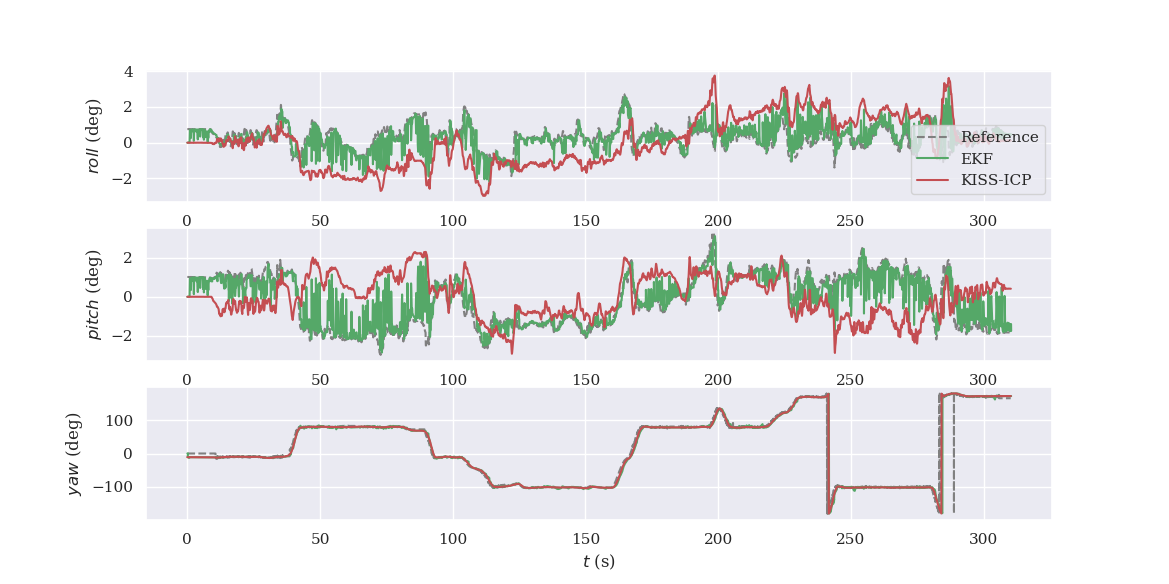

In [100]:
# Compare a single Run
run = 2
trajectories, names = [v for v in data[f"run_{run:02d}"].values()], [k for k in data[f"run_{run:02d}"].keys()]
compare_plot_multiple(trajectories, names, plot_mode='rpy')

In [ ]:
# Compare data across all runs of one test set
trajectory_type = "EKF"
trajectories, names = [],[]
for i in range(1, N_RUNS+1):
    run = f"run_{i:02d}"
    names.append(run)
    trajectories.append(data[run][trajectory_type])

names.append("Reference")
trajectories.append(data[run]["Reference"])
compare_plot_multiple(trajectories, names, plot_mode='rpy', wf=2, hf=0.5)

In [ ]:
# Compare for Errors
run = 1
trajectory_type = "EKF"
traj_pair = (data[f"run_{run:02d}"]['Reference'], data[f"run_{run:02d}"][trajectory_type])
plot_compare(traj_pair, plot_mode='ape', est_name=trajectory_type, print_stats=True, pose_relation=PoseRelation.translation_part)

### KISS-ICP via Python API Test

In [ ]:
test_set = "full_merge"
python_api_root = f"data/kiss_python/{test_set}/"

python_runs = [(file_interface.read_tum_trajectory_file(path.join(python_api_root, f"run_{run:02d}" ,"gps.tum")),
                file_interface.read_tum_trajectory_file(path.join(python_api_root, f"run_{run:02d}" ,"odometry.tum"))) for run in range(1,4)]

kiss_python_path = 'data/kiss_python/full_merge/odometry.tum'
gps_python_path = 'data/kiss_python/full_merge/gps.tum'
# traj_kiss_python = file_interface.read_tum_trajectory_file(kiss_python_path)
# traj_gps_python = file_interface.read_tum_trajectory_file(gps_python_path)
# kiss_python_compare_traj = (traj_gps_python, traj_kiss_python)

In [ ]:
plot_trajectories_from_poses(traj_ref, [python_runs[i][1] for i in range(len(python_runs))], "KISS-ICP")

In [ ]:
kiss_runs = [run[1] for run in python_runs]
compare_plot_multiple(kiss_runs, [f"run_{i}" for i in range(1,4)], plot_mode='xyz')

In [ ]:
pose_relation = PoseRelation.translation_part
title = ""

metric_result = plot_compare(python_runs[0], print_stats=False, plot_mode='xyz', est_name="KISS-ICP", pose_relation=pose_relation, title=title)
# plt.savefig(f"tmp/com2.pdf", format="pdf", bbox_inches="tight")
# print(metric_result.pretty_str())

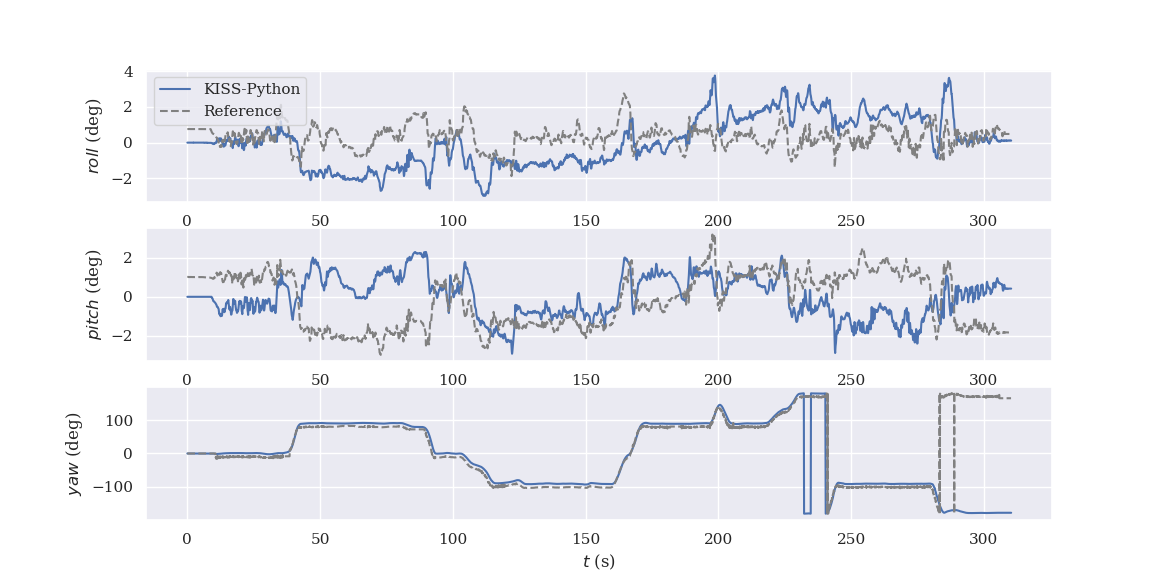

In [98]:
# Compare Python KISS to ROS KISS
# compare_plot_multiple([python_runs[0][1], traj_ekf], ["KISS-Python", "EKF"], plot_mode='rpy')
compare_plot_multiple([kiss_traj, traj_ref], ["KISS-Python", "Reference"], plot_mode='rpy')


### KISS full initial orientation

In [94]:

euler = R.from_quat(traj_ref.orientations_quat_wxyz[0]).as_euler('zyx', degrees=True)
# rot = R.from_euler('zyx', [euler[0], euler[1], -11]).as_matrix()
rot = R.from_euler('zyx', [0, 0, -11]).as_matrix()


In [97]:
kiss_traj = file_interface.read_tum_trajectory_file("data/ekf_analysis/v3/odometry.tum")
# origin_se3 = np.eye(4)
# origin_se3[:3,:3] = rot
# ref_pose_origin = PosePath3D(poses_se3=[origin_se3])
# kiss_traj.align_origin(ref_pose_origin)

## Interactive

In [ ]:
# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

In [ ]:
ape_metric = metrics.APE()
ape_metric.process_data((traj_ref, traj_est))
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)
plot_ape_errors(traj_ref, traj_est, ape_metric, ape_stats)

In [ ]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})


In [ ]:
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})